Zuerst laden wir wieder einige Python-Module.

In [1]:
import numpy as np
from math import sin, exp, pi
from scipy.optimize import linprog
import matplotlib.pyplot as plt

Nun definieren wir die Ansatzfunktionen $f_1(x) = \sin(2\,\pi\,x)$, $f_2(x) = \mathrm{e}^x$ und $f_3(x) = x^2$. Unser Modell ist also $f(x,p) = p_1\,f_1(x) + p_2\,f_2(x) + p_3\,f_3(x)$.

In [2]:
def f1(x):
	return sin(2*pi*x)
def f2(x):
	return exp(x)
def f3(x):
	return x**2

n = 3
f = [f1, f2, f3]

Wir legen den wahren Parameter fest, der weiter unten identifiziert werden soll.

In [3]:
p = np.array([1, 2, 3])

Jetzt werden die Messpunkte im Intervall $[0,1]$ erstellt.

In [4]:
m = 51
x = np.linspace(0,1,m)

Es sollen verrauschte Messwerte erzeugt werden. Diese werden mit einer Standardnormalverteilung mit Mittelwert $0$ und einer gewissen Varianz erzeugt. Um Ausreißer zu generieren, werden zusätzlich ein Teil der Punkte stärker verrauscht.

In [5]:
# Das Rauschlevel für alle Punkte
noise_level = 0.05

# Wieviel Punkte werden stärker verrauscht?
prob = .1
noise_level_2 = 3.

Nun können wir die verrauschten Messwerte erzeugen.

In [6]:
y = np.zeros([m])
for j in range(m):
	y[j] = 0
	# Auswertung der Funktionen
	for i in range(n):
		y[j] += p[i] * f[i]( x[j] )

	# Verrauschen
	y[j] += noise_level * np.random.randn()

	# Zusätzliches Verrauschen für Ausreißer
	if np.random.rand() < prob:
		y[j] += noise_level_2 * np.random.randn()

Als nächstes erstellen wir eine Matrix $A$, sodass für einen Parametervektor $p$ der Vektor $A\,p$ gerade die Messwerte liefert, die sich mit dem Parameter $p$ ergeben.

In [7]:
A = np.zeros([m,n])
for j in range(m):
	for i in range(n):
		A[j,i] = f[i]( x[j] )

Zunächst berechnen wir die Lösung des kleinsten-Quadrate-Problems
$$
\text{Minimiere}\quad \| A \, p - y \|^2 = \sum_{i=1}^m ((A\,p)_i - y_i)^2 \quad\text{bzgl. }p.
$$
Dieses erhält man durch die Lösung der Normalengleichung
$$
(A^\top A) p = A^\top y.$$

In [8]:
p1 = np.linalg.solve( A.T.dot(A), A.T.dot(y))
print('Lösung mittels kleinster Quadrate:\n%s' % np.array2string(p1))

Lösung mittels kleinster Quadrate:
[1.18329757 2.16364921 2.0199148 ]


Wir sehen, dass die Lösung nicht besonders gut ist. Dies liegt hauptsächlich an den Ausreißern.

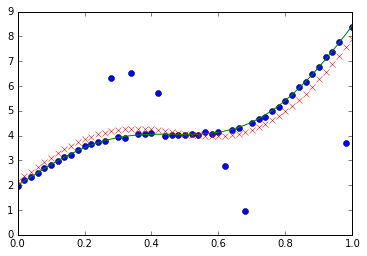

In [9]:
fig, ax = plt.subplots()

ax.plot(x, y, 'o')
ax.plot(x, A.dot(p), '-')
ax.plot(x, A.dot(p1), 'x')

plt.show()

Nun lösen wir ein zweites Problem, bei dem wir die Absolutwerte der Fehler summieren, also
$$
\text{Minimiere}\quad \sum_{i=1}^m \bigl|(A\,p)_i - y_i\bigr| \quad\text{bzgl. }p.
$$
In dieser Form ist das Problem recht schwer zu lösen. Allerdings werden wir sehen, dass wir das Problem durch einen einfachen Trick in ein lineares Optimierungsproblem umwandeln können. Dafür benötigen wir Hilfsvariablen $z_i$, $i = 1,\ldots,m$. Mit den Ungleichungen
$$
(A\,p)_i - y_i \le z_i
\quad\text{und}\quad
-((A\,p)_i - y_i) \le z_i
$$
können wir sicherstellen, dass
$$
\bigl| (A\,p)_i - y_i \bigr| \le z_i
$$
gilt. Nun minimieren wir die Summe der $z_i$ und dies hat zur Folge, dass in der Lösung die obige Ungleichung mit Gleichheit erfüllt ist. Damit müssen wir also das Problem
\begin{align*}
\text{Minimiere}\quad& \sum_{i=1}^m z_i\\
\text{bzgl.}\quad& y,z\\
\text{u.d.N.}\quad& A \, p - z \le y \\
& -A\,p - z \le -y
\end{align*}

Zunächst generieren wir die Daten für das Problem.

In [10]:
Q = np.bmat( ((A, -np.eye(m,m)),(-A, -np.eye(m,m))) )
c = np.hstack((np.zeros(n), np.ones(m)))
b = np.hstack((y,-y))

Nun können wir das Problem lösen. (Um zuverlässig eine Lösung zu erhalten, müssen wir noch die Optionen anpassen).

In [11]:
sol = linprog(c, A_ub = Q, b_ub = b, bounds = (None, None), options = {'maxiter': 100*m, "tol" : 1e-8})
print(sol.message)
print('Anzahl Iterationen: %d\n' % sol.nit )
p2 = sol.x[:3]
print('Lösung mittels Fehlersumme:\n%s' % np.array2string(p2))

Optimization terminated successfully.
Anzahl Iterationen: 137

Lösung mittels Fehlersumme:
[1.04485501 1.98163142 3.10516708]


Nun können wir die beiden Lösungen vergleichen.

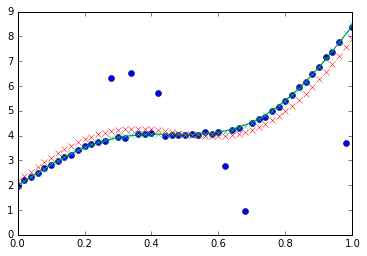

In [12]:
fig, ax = plt.subplots()

ax.plot(x, y, 'o')
ax.plot(x, A.dot(p), '-')
ax.plot(x, A.dot(p1), 'x')
ax.plot(x, A.dot(p2), 'x')

plt.show()